## GAN 2D

References
- http://blog.naver.com/atelierjpro/220987973950
- https://matplotlib.org/examples/pylab_examples/scatter_hist.html

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import tensorflow as tf
%matplotlib inline

# Disable GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
NUM_DATA = 10 ** 3
x_real = np.column_stack((np.random.normal(0.25, 0.15, size=NUM_DATA), np.random.normal(-0.25, 0.1, size=NUM_DATA)))

In [3]:
class GAN:
    def __init__(self, dim_z, dim_h1, dim_h2, dim_x):
        self.dim_x = dim_x
        self.dim_h1 = dim_h1
        self.dim_h2 = dim_h2
        self.dim_z = dim_z
#         my_init = tf.truncated_normal_initializer(stddev=0.2)
        my_init = tf.random_uniform_initializer(-1, 1)
        
        # Placeholders
        self.x = tf.placeholder(tf.float32, [None, self.dim_x])
        self.z = tf.placeholder(tf.float32, [None, self.dim_z])
        self.lr = tf.placeholder(tf.float32)
        
        # Generator
        with tf.variable_scope('G'):
            G_h1   = tf.layers.dense(self.z, self.dim_h1, kernel_initializer=my_init, activation=tf.tanh)
            G_h2   = tf.layers.dense(G_h1,   self.dim_h2, kernel_initializer=my_init, activation=tf.tanh)
            self.G = tf.layers.dense(G_h2,   self.dim_x,  kernel_initializer=my_init, activation=tf.tanh)
        
        # Discriminator
        with tf.variable_scope('D') as scope:
            def discriminator(inputs):
                D_h1 = tf.layers.dense(inputs, self.dim_h2,
                                       activation=tf.tanh,    kernel_initializer=my_init, name='D_h1')
                D_h2 = tf.layers.dense(D_h1,   self.dim_h1,
                                       activation=tf.tanh,    kernel_initializer=my_init, name='D_h2')
                D    = tf.layers.dense(D_h2,   1,
                                       activation=tf.sigmoid, kernel_initializer=my_init, name='D')
                return D
            self.D_real = discriminator(self.x)
            scope.reuse_variables()
            self.D_fake = discriminator(self.G)
        
        # Losses
        self.loss_G      = tf.reduce_mean(-tf.log(self.D_fake))
        self.loss_D_real = tf.reduce_mean(-tf.log(self.D_real))
        self.loss_D_fake = tf.reduce_mean(-tf.log(1 - self.D_fake))
        self.loss_D      = tf.reduce_mean((self.loss_D_real, self.loss_D_fake))
        
        # Optmizers
        def optimizer(loss, var_list):
            return tf.train.AdamOptimizer(self.lr).minimize(loss, var_list=var_list)
        g_params = [v for v in tf.trainable_variables() if v.name.startswith('G/')]
        d_params = [v for v in tf.trainable_variables() if v.name.startswith('D/')]
        self.train_G = optimizer(self.loss_G, g_params)
        self.train_D = optimizer(self.loss_D, d_params)
    
    def generate_noise(self, cnt):
        return np.random.normal(0, 1, size=[cnt, self.dim_z])
    
    def train(self, sess, x, lr, train_D_only=False):
        noise = self.generate_noise(x.shape[0])
        sess.run(self.train_D, feed_dict={self.x: x, self.z: noise, self.lr: lr})
        if not train_D_only:
            sess.run(self.train_G, feed_dict={           self.z: noise, self.lr: lr})
        
    def loss(self, sess, x):
        noise = self.generate_noise(x.shape[0])
        loss_G = sess.run(self.loss_G, feed_dict={           self.z: noise})
        loss_D = sess.run(self.loss_D, feed_dict={self.x: x, self.z: noise})
        return loss_G, loss_D
    
    def generate_data(self, sess, noise):
        return sess.run(self.G, feed_dict={self.z: noise})

In [4]:
def plot_data(x_real, x_fake, frame_str, path=None):
    # Start plot
    plt.ioff()
    plt.figure(figsize=(9, 9.5))
    plt.rc('font', size=15)
    plt.title('GAN for 2D Data (%s frame)'%(frame_str), fontsize=15, family='monospace')
    plt.axis('off')
    
    # Define values
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.55
    bottom_h = bottom + height + 0.02
    left_h = left + width + 0.02
    plot_bins = np.arange(-1, 1 + 0.0001, 0.0001)
    hist_bins = np.arange(-1, 1 + 0.025, 0.025)
    
    # Generate multiple axes
    ax_2d = plt.axes([left, bottom, width, height])
    ax_x1 = plt.axes([left, bottom_h, width, 0.2])
    ax_x2 = plt.axes([left_h, bottom, 0.2, height])
    
    def disable_ticks(target):
        target.tick_params(axis='both', which='both',
                           bottom='off', top='off', left='off', right='off',
                           labelbottom='off', labeltop='off', labelleft='off', labelright='off')
    disable_ticks(ax_2d)
    disable_ticks(ax_x1)
    disable_ticks(ax_x2)
    
    ax_2d.tick_params(axis='both', which='major', bottom='on', left='on', labelbottom='on', labelleft='on')
    ax_x1.tick_params(axis='both', which='major', bottom='on')
    ax_x2.tick_params(axis='both', which='major', left='on')
    
    # Draw 2D
    ax_2d.scatter(x_fake[:,0], x_fake[:,1], s=30, c='red',  alpha=0.25)
    mesh_grid = np.mgrid[-1:1:0.01, -1:1:0.01]
    from scipy.stats import multivariate_normal
    rv = multivariate_normal([np.mean(x_real[:,0]), np.mean(x_real[:,1])], [[np.std(x_real[:,0]), 0], [0, np.std(x_real[:,1])]])
    ax_2d.contour(mesh_grid[0], mesh_grid[1], rv.pdf(np.dstack((mesh_grid[0], mesh_grid[1]))), 10, cmap='Blues', linewidths=2.5)
    ax_2d.set_xlim((-1, 1))
    ax_2d.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax_2d.set_ylim((-1, 1))
    ax_2d.set_yticks([-1, -0.5, 0, 0.5, 1])
    
    # Draw x_1
    ax_x1.hist(x_fake[:,0], hist_bins, normed=1, facecolor='red', alpha=0.5, histtype='bar', rwidth=0.8)
    ax_x1.plot(plot_bins, mlab.normpdf(plot_bins, x_real[:,0].mean(), x_real[:,0].std()), 'b-', linewidth=2.5)
    ax_x1.set_xlim((-1, 1))
    ax_x1.set_ylim((0, 4))
    ax_x1.set_xticks([-1, -0.5, 0, 0.5, 1])
    
    # Draw x_2
    ax_x2.hist(x_fake[:,1], hist_bins, normed=1, facecolor='red', alpha=0.5, histtype='bar', rwidth=0.8, orientation='horizontal')    
    ax_x2.plot(mlab.normpdf(plot_bins, x_real[:,1].mean(), x_real[:,1].std()), plot_bins, 'b-', linewidth=2.5)
    ax_x2.set_xlim((0, 6))
    ax_x2.set_ylim((-1, 1))
    ax_x2.set_yticks([-1, -0.5, 0, 0.5, 1])

    # Finish the work
    path == None and plt.show() or plt.savefig(path, bbox_inches='tight')
    plt.close()

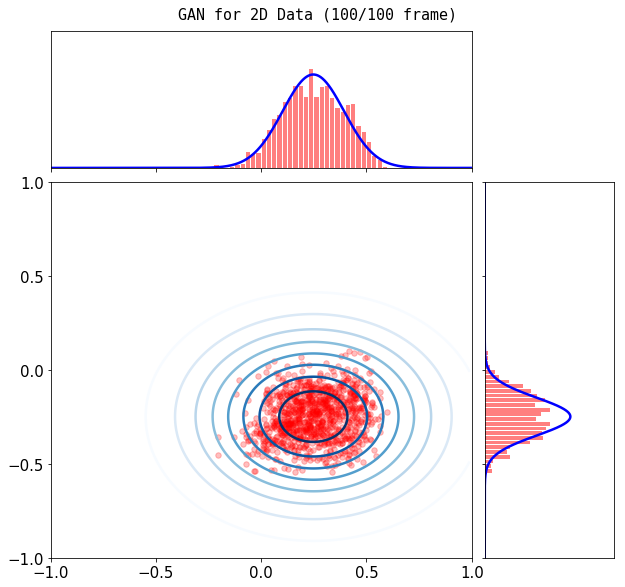

In [5]:
tf.reset_default_graph()

with tf.Session() as sess:
    gan = GAN(dim_z=2**5, dim_h1=2**4, dim_h2=2**3, dim_x=2)
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    fixed_noise = gan.generate_noise(NUM_DATA)
        
    BATCH_SIZE = 2 ** 6
    NUM_ITER = 100001
    num_img = 0
    
    # Draw first frame of the animation
    x_fake = gan.generate_data(sess, fixed_noise)
    plot_data(x_real, x_fake, '%3d/%d'%(num_img, 100), 'plot_gan2d/%d.png'%num_img)
    
    for iter in xrange(NUM_ITER):
        # Train
        x_batch = x_real[[random.randint(a=0, b=x_real.shape[0]-1) for _ in range(BATCH_SIZE)]]
        lr = 0.00005 * (1 - float(iter) / NUM_ITER)
        if iter % 2 == 0:
            gan.train(sess, x_batch, lr)
        else:
            gan.train(sess, x_batch, lr, train_D_only=True)
        
        # Draw a frame of the animation
        if iter > 0 and iter % 1000 == 0:
            x_fake = gan.generate_data(sess, fixed_noise)
            num_img += 1
            plot_data(x_real, x_fake, '%3d/%d'%(num_img, 100), 'plot_gan2d/%d.png'%num_img)
         
        # Plot the result
        if iter == (NUM_ITER-1):
            x_fake = gan.generate_data(sess, fixed_noise)
            plot_data(x_real, x_fake, '%3d/%d'%(num_img, 100))